# Graph Neural Network Edge Prediction on Cora Dataset

## Introduction

This project explores the fascinating problem of **edge prediction** in citation networks through a comparative analysis of two powerful machine learning approaches: Deep Neural Networks (DNN) and Graph Neural Networks (GNN).

### The Challenge

Edge prediction is a fundamental task in network analysis that involves determining whether a connection should exist between two nodes based on their features and the existing graph structure. In the context of academic citations, this translates to predicting whether one paper should cite another based on their content and citation patterns.

### Dataset Overview

We utilize the well-established **Cora dataset**, which represents a rich citation network consisting of:
- **2,708 scientific publications** classified into seven distinct research areas
- **5,429 citation links** forming the network structure  
- **1,433-dimensional feature vectors** for each publication, representing word presence/absence from a curated dictionary

This dataset provides an ideal testbed for comparing different approaches to graph-based machine learning, as it combines both rich node features and meaningful network topology.

### Research Objectives

This project addresses two key research questions:

1. **Methodological Comparison**: How do traditional deep learning approaches (DNN) compare against graph-specific architectures (GNN) for edge prediction tasks?

2. **Architecture Design**: What are the optimal strategies for formulating edge prediction as a machine learning problem, particularly when dealing with graph-structured data?

### Technical Approach

I implement and evaluate two distinct methodologies:

- **Deep Neural Network (DNN)**: A traditional approach that treats edge prediction as a classification task using engineered features from node pairs
- **Graph Neural Network (GNN)**: A graph-aware approach that leverages message passing to learn node embeddings while incorporating network topology

Through rigorous experimentation and analysis, I examine the strengths, limitations, and practical considerations of each approach, providing insights into when and why different architectures excel in graph-based prediction tasks.

# CORA dataset download and processing

In [ ]:
import os
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc

### Dataset download

In [ ]:
# Download CORA dataset. This dataset contains two files
# - cora.cites: contains the citation graph of the corpus: <ID of cited paper> <ID of citing paper>
# - cora.content: contains descriptions of the papers: <paper_id> <word_attributes>+ <class_label>
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 ━━━━━━━━━━━━━━━━━━━━ 1s 4us/step


## 1. Coding tasks

In [ ]:
# Fix for directory structure - the extraction creates a "cora_extracted" folder with a "cora" subfolder
extracted_dir = os.path.join(os.path.dirname(zip_file), "cora_extracted")
if os.path.exists(extracted_dir) and os.path.isdir(extracted_dir):
    if "cora" in os.listdir(extracted_dir):
        data_dir = os.path.join(extracted_dir, "cora")
    else:
        data_dir = extracted_dir
else:
    data_dir = os.path.join(os.path.dirname(zip_file), "cora")

# Print directory information for debugging
print(f"Using data directory: {data_dir}")
print(f"Directory exists: {os.path.exists(data_dir)}")
if os.path.exists(data_dir):
    print(f"Contents: {os.listdir(data_dir)}")

Using data directory: /root/.keras/datasets/cora_extracted/cora
Directory exists: True
Contents: ['cora.content', 'README', 'cora.cites']


In [ ]:
## 1.1 Preprocess the dataset and formulate the edge prediction task

# Read cora.cites
citations = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep="\t", header=None, names=["target", "source"])
print("Citations shape:", citations.shape)

# Read cora.content
column_names = ["paper_id"] + [f"word_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names)
print("Papers shape:", papers.shape)

# Get list of unique paper subjects / classes
class_values = sorted(papers["subject"].unique())
class_idx = {name: idx for idx, name in enumerate(class_values)}

# Generate mapping for paper indices
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

# Map the original papers and citations information to the new indices
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])

# Create node features array
feature_names = set(papers.columns) - {"paper_id", "subject"}
node_features = papers.sort_values("paper_id")[list(feature_names)].to_numpy()

# Edge prediction task formulation

# Positive edges: Existing edges in the graph
positive_edges = citations[["source", "target"]].to_numpy()

# Create all possible edges
n_nodes = len(papers)
all_edges = []
for i in range(n_nodes):
    for j in range(n_nodes):
        if i != j:  # Avoid self-loops
            all_edges.append((i, j))

all_edges = np.array(all_edges)

# Create a set of positive edges for faster lookup
positive_edge_set = set(map(tuple, positive_edges))

# Sample negative edges (non-existing edges in the graph)
negative_edges = []
for edge in all_edges:
    if tuple(edge) not in positive_edge_set:
        negative_edges.append(edge)
        # Sample the same number of negative edges as positive edges
        if len(negative_edges) == len(positive_edges):
            break

negative_edges = np.array(negative_edges)

# Combine positive and negative edges
all_edge_examples = np.vstack((positive_edges, negative_edges))
all_edge_labels = np.concatenate([np.ones(len(positive_edges)), np.zeros(len(negative_edges))])

Citations shape: (5429, 2)
Papers shape: (2708, 1435)


In [ ]:
# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_edge_examples, all_edge_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (7600, 2)
Validation set: (1629, 2)
Test set: (1629, 2)


In [ ]:
## 1.2 Implement the DNN-based edge prediction model

# Feature extraction for edges
def extract_edge_features(edges, node_features):
    """
    Extract features for edges by combining the features of the source and target nodes.
    For DNN, we combine the node features through concatenation, element-wise product, and element-wise difference.
    """
    src_node_features = node_features[edges[:, 0]]
    dst_node_features = node_features[edges[:, 1]]

    # Concatenate features
    concat_features = np.concatenate([src_node_features, dst_node_features], axis=1)

    # Element-wise product of features (hadamard product)
    product_features = src_node_features * dst_node_features

    # Element-wise absolute difference
    diff_features = np.abs(src_node_features - dst_node_features)

    # Combine all feature extraction methods
    combined_features = np.concatenate([concat_features, product_features, diff_features], axis=1)

    return combined_features

# Extract features for training, validation, and test sets using DNN approach
X_train_dnn = extract_edge_features(X_train, node_features)
X_val_dnn = extract_edge_features(X_val, node_features)
X_test_dnn = extract_edge_features(X_test, node_features)

In [ ]:
# Define DNN model
def create_dnn_edge_prediction_model(input_dim, hidden_units, dropout_rate):
    """
    Create a DNN model for edge prediction
    """
    inputs = layers.Input(shape=(input_dim,))

    # Feed Forward Network
    x = inputs
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.BatchNormalization()(x)

    # Add some residual blocks
    for block_idx in range(3):
        block_input = x
        for units in hidden_units:
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.BatchNormalization()(x)
        x = layers.Add()([x, block_input])  # Skip connection

    # Output layer for binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="DNN_Edge_Prediction")
    return model

# Set hyperparameters
hidden_units = [64, 32]
dropout_rate = 0.5
input_dim = X_train_dnn.shape[1]

# Create and compile DNN model
dnn_model = create_dnn_edge_prediction_model(input_dim, hidden_units, dropout_rate)
dnn_model.summary()

# Compile the model
dnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy"),
             keras.metrics.AUC(name="auc")]
)

Model: "DNN_Edge_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5732)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    366,912 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      2,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32)        │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      2,112 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_4[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32)        │          0 │ batch_normalizat

 Total params: 383,137 (1.46 MB)

 Trainable params: 382,369 (1.46 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
## 1.3 Implement the GNN-based edge prediction model

# Define a Graph Neural Network Layer
class GNNLayer(layers.Layer):
    """
    Graph Neural Network Layer for learning node embeddings
    """
    def __init__(self, hidden_units, dropout_rate):
        super().__init__()

        # Create FFN for preparing messages
        self.prepare_message = self.create_ffn(hidden_units, dropout_rate)

        # Create FFN for updating node embeddings
        self.update_node = self.create_ffn(hidden_units, dropout_rate)

    def create_ffn(self, hidden_units, dropout_rate):
        """Create a Feed Forward Network"""
        ffn_layers = []
        for units in hidden_units:
            ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
            ffn_layers.append(layers.Dropout(dropout_rate))
            ffn_layers.append(layers.BatchNormalization())
        return keras.Sequential(ffn_layers)

    def aggregate(self, neighbor_messages, node_indices, num_nodes):
        """Aggregate messages from neighbors using sum aggregation"""
        return tf.math.unsorted_segment_sum(
            neighbor_messages, node_indices, num_segments=num_nodes
        )

    def call(self, inputs):
        """
        Forward pass of the GNN layer
        inputs: (node_features, edges)
        """
        node_features, edges = inputs

        # Get source and target node indices
        source_indices, target_indices = edges[0], edges[1]

        # Get number of nodes
        num_nodes = tf.shape(node_features)[0]

        # Get messages from target nodes to source nodes
        target_node_features = tf.gather(node_features, target_indices)
        messages = self.prepare_message(target_node_features)

        # Aggregate messages at source nodes
        aggregated_messages = self.aggregate(messages, source_indices, num_nodes)

        # Update node features with aggregated messages
        updated_node_features = node_features + self.update_node(aggregated_messages)

        # Normalize updated node features
        updated_node_features = tf.nn.l2_normalize(updated_node_features, axis=1)

        return updated_node_features

# Define a GNN model for edge prediction
class GNNEdgePredictionModel(keras.Model):
    """
    Graph Neural Network Model for Edge Prediction
    """
    def __init__(self, node_features, edges, hidden_units, dropout_rate):
        super().__init__()

        # Store node features and edges
        self.node_features = tf.cast(node_features, dtype=tf.float32)
        self.edges = tf.cast(edges, dtype=tf.int32)

        # Create node preprocessing layer
        self.preprocess = self.create_ffn(hidden_units, dropout_rate)

        # Create GNN layers
        self.gnn_layers = [
            GNNLayer(hidden_units, dropout_rate),
            GNNLayer(hidden_units, dropout_rate)
        ]

        # Create edge scoring layer
        self.edge_score = keras.Sequential([
            layers.Dense(hidden_units[0], activation=tf.nn.gelu),
            layers.Dropout(dropout_rate),
            layers.BatchNormalization(),
            layers.Dense(1, activation="sigmoid")
        ])

    def create_ffn(self, hidden_units, dropout_rate):
        """Create a Feed Forward Network"""
        ffn_layers = []
        for units in hidden_units:
            ffn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
            ffn_layers.append(layers.Dropout(dropout_rate))
            ffn_layers.append(layers.BatchNormalization())
        return keras.Sequential(ffn_layers)

    def call(self, edge_examples):
        """
        Forward pass of the GNN model
        edge_examples: tensor of shape [batch_size, 2] containing edge source and target indices
        """
        # Preprocess node features
        x = self.preprocess(self.node_features)

        # Apply GNN layers with skip connections
        for gnn_layer in self.gnn_layers:
            x1 = gnn_layer((x, self.edges))
            x = x + x1  # Skip connection

        # Extract embeddings for edge nodes
        source_embeddings = tf.gather(x, edge_examples[:, 0])
        target_embeddings = tf.gather(x, edge_examples[:, 1])

        # Combine embeddings (concatenate, hadamard, l1)
        concat_embeddings = tf.concat([source_embeddings, target_embeddings], axis=1)
        hadamard_embeddings = source_embeddings * target_embeddings
        l1_embeddings = tf.abs(source_embeddings - target_embeddings)

        # Combine all embeddings
        combined_embeddings = tf.concat(
            [concat_embeddings, hadamard_embeddings, l1_embeddings], axis=1
        )

        # Score the edge
        edge_scores = self.edge_score(combined_embeddings)

        return edge_scores

In [ ]:
# Prepare edges for GNN (required format: [2, num_edges])
edges_array = citations[["source", "target"]].to_numpy().T

# Create and compile GNN model
gnn_model = GNNEdgePredictionModel(
    node_features=node_features,
    edges=edges_array,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate
)

# Compile the model
gnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy"),
             keras.metrics.AUC(name="auc")]
)

# Build the model with sample input to initialize weights
_ = gnn_model(tf.convert_to_tensor(X_train[:5]))
gnn_model.summary()

Model: "gnn_edge_prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (2708, 32)             │        94,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gnn_layer (GNNLayer)            │ ?                      │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gnn_layer_1 (GNNLayer)          │ ?                      │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (5, 1)                 │         8,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,121 (473.13 KB)

 Trainable params: 120,033 (468.88 KB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
## 1.4 Train and evaluate both models

# Function to plot learning curves
def plot_learning_curves(history, model_name):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot loss
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.set_title(f"{model_name} Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(["train", "validation"])

    # Plot accuracy
    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.set_title(f"{model_name} Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["train", "validation"])

    # Plot AUC
    ax3.plot(history.history["auc"])
    ax3.plot(history.history["val_auc"])
    ax3.set_title(f"{model_name} AUC")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("AUC")
    ax3.legend(["train", "validation"])

    plt.tight_layout()
    plt.show()

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    # Predict probabilities
    y_pred_prob = model.predict(X_test).flatten()

    # Convert probabilities to binary predictions
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {auc_score:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    return {
        "accuracy": accuracy,
        "roc_auc": auc_score,
        "pr_auc": pr_auc
    }

In [ ]:
# Train and evaluate DNN model
print("\nTraining DNN model...")
history_dnn = dnn_model.fit(
    X_train_dnn, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_dnn, y_val),
    verbose=1
)


Training DNN model...
Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.9000 - auc: 0.9461 - loss: 0.2518 - val_accuracy: 0.9988 - val_auc: 0.9994 - val_loss: 0.0119
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9926 - auc: 0.9993 - loss: 0.0235 - val_accuracy: 0.9994 - val_auc: 0.9994 - val_loss: 0.0080
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9961 - auc: 0.9995 - loss: 0.0129 - val_accuracy: 0.9994 - val_auc: 0.9994 - val_loss: 0.0093
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9977 - auc: 0.9995 - loss: 0.0102 - val_accuracy: 0.9994 - val_auc: 0.9994 - val_loss: 0.0078
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9941 - auc: 0.9986 - loss: 0.0209 - val_accuracy: 0.9994 - val_auc: 0.9994 - val_loss: 0.0079
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9965 - auc: 0.9996 - loss: 0.0123 - val_accuracy: 0.9994 - val_auc: 0.9994 - val_loss: 0.0083
Epoch 7/50
119/

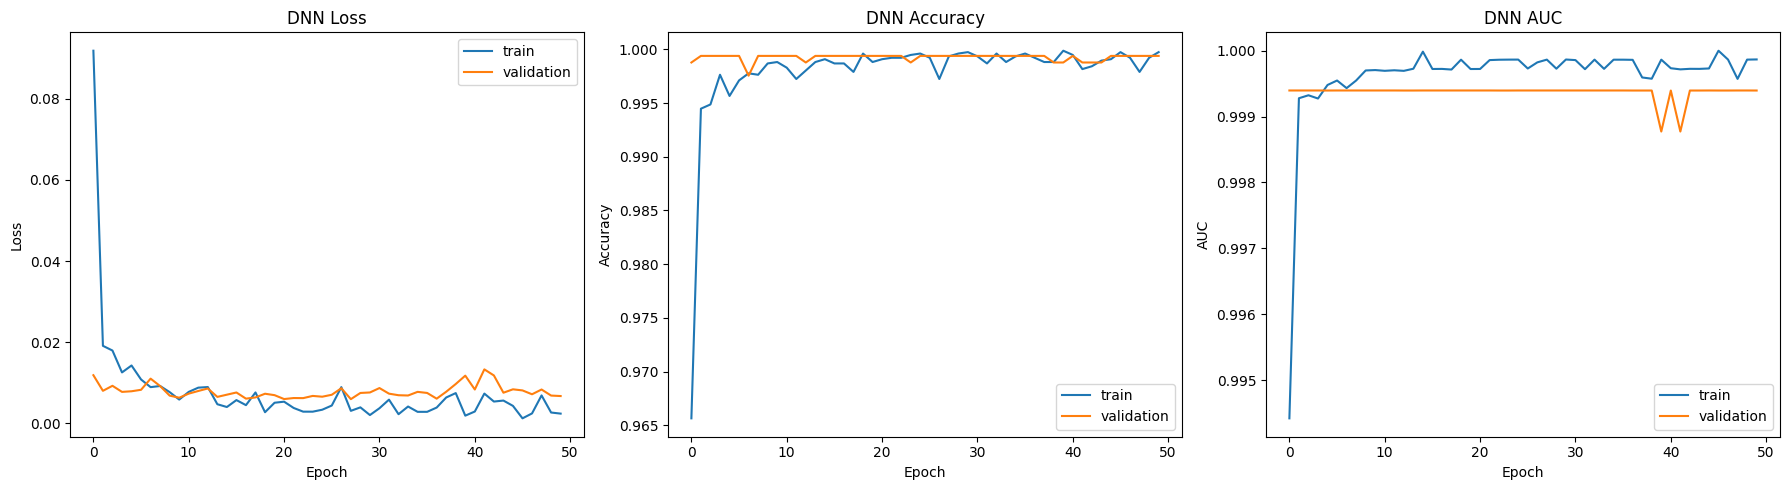

In [ ]:
# Plot learning curves for DNN
plot_learning_curves(history_dnn, "DNN")

In [ ]:
# Evaluate DNN model on test set
dnn_metrics = evaluate_model(dnn_model, X_test_dnn, y_test, "DNN")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

DNN Evaluation Metrics:
Accuracy: 0.9994
ROC AUC: 1.0000
PR AUC: 1.0000


In [ ]:
# Train and evaluate GNN model
print("\nTraining GNN model...")
history_gnn = gnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


Training GNN model...
Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9756 - auc: 0.9916 - loss: 0.0665 - val_accuracy: 0.9988 - val_auc: 0.9988 - val_loss: 0.0096
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - auc: 0.9999 - loss: 0.0010 - val_accuracy: 0.9994 - val_auc: 0.9994 - val_loss: 0.0034
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9973 - auc: 0.9977 - loss: 0.0302 - val_accuracy: 0.9969 - val_auc: 0.9969 - val_loss: 0.1989
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9960 - auc: 0.9984 - loss: 0.0911 - val_accuracy: 0.9994 - val_auc: 0.9994 - val_loss: 0.0278
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9994 - auc: 0.9998 - loss: 0.0036 - val_accuracy: 0.9994 - val_auc: 1.0000 - val_loss: 0.0026
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - auc: 0.9998 - loss: 0.0020 - val_accuracy: 0.9988 - val_auc: 0.9994 - val_loss: 0.0071
Epoch 7/50
119

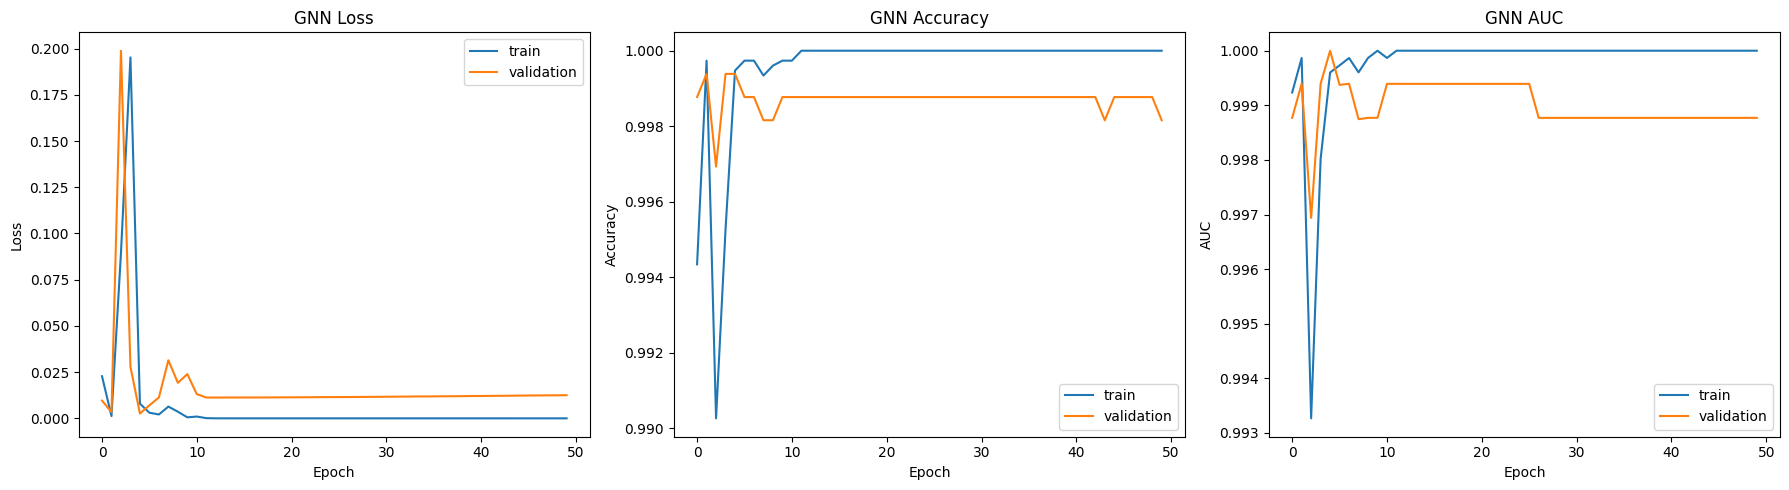

In [ ]:
# Plot learning curves for GNN
plot_learning_curves(history_gnn, "GNN")

In [ ]:
# Evaluate GNN model on test set
gnn_metrics = evaluate_model(gnn_model, X_test, y_test, "GNN")

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

GNN Evaluation Metrics:
Accuracy: 0.9994
ROC AUC: 0.9994
PR AUC: 0.9994


In [ ]:
# Compare model performance
print("\nModel Performance Comparison:")
print(f"{'Metric':<15} {'DNN':<10} {'GNN':<10}")
print("-" * 35)
for metric in dnn_metrics:
    print(f"{metric:<15} {dnn_metrics[metric]:<10.4f} {gnn_metrics[metric]:<10.4f}")



Model Performance Comparison:
Metric          DNN        GNN       
-----------------------------------
accuracy        0.9994     0.9994    
roc_auc         1.0000     0.9994    
pr_auc          1.0000     0.9994    
